In [2]:
import pandas as pd
import requests as rq
import json
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from matplotlib import pyplot
import statsmodels.api as sm
from scipy.fft import fft, fftfreq
from retrying import retry
import requests 

In [3]:
url = "https://giris.epias.com.tr"
 
headertgt = {"Content-Type" : "application/x-www-form-urlencoded",
             "Accept" : "text/plain"}
 
paramtgt = {"username" : "adem.yildirim@statkraft.com",
            "password" : "Ay.44444"}
 
TGT_response = requests.post(url+"/cas/v1/tickets", headers = headertgt, params = paramtgt)

In [4]:
date1 = "2023-01-01T00:00:00+03:00"
date2 = "2023-12-31T00:00:00+03:00" #sontarihin tamamını alıyor
base_path = "https://seffaflik.epias.com.tr/electricity-service"
header={"Content-Type" : "application/json",
        "Accept" : "application/json",
        "Accept-Language" :"en",
        "TGT" : TGT_response.text}

In [5]:
ptfparam1  = json.dumps({"startDate": date1, "endDate": date2,"page": {"number": "", "size": "", "total": "", "sort": {"field": "date",  "direction": "ASC"}}})
ptf1  = rq.request("POST", base_path+"/v1/markets/dam/data/mcp",  data = ptfparam1, headers=header)
ptf1  = ptf1.json()
ptf   = pd.DataFrame(ptf1["items"])

In [6]:
consumption1  = rq.request("POST", base_path+"/v1/consumption/data/realtime-consumption",  data = ptfparam1, headers=header)
consumption1  = consumption1.json()
consumption1  = pd.DataFrame(consumption1["items"])
consumption   = consumption1 

In [7]:
production1  = rq.request("POST", base_path+"/v1/generation/data/realtime-generation",  data = ptfparam1, headers=header)
production1 = production1.json()
production1 = pd.DataFrame(production1["items"])
production01   = production1 

In [8]:
production11  = rq.request("POST", base_path+"/v1/renewables/data/unlicensed-generation-amount",  data = ptfparam1, headers=header)
production11 = production11.json()
production11 = pd.DataFrame(production11["items"])
production02   = production11

In [9]:
ptf          = ptf 
consumption  = consumption.drop(columns=['date', 'time'])
production01 = production01.drop(columns=['date', 'hour'])
production02 = production02.drop(columns=['date', 'time'])
hourlydata = pd.concat([ptf.reset_index(), consumption.reset_index(), production01.reset_index(), production02.reset_index()], axis = 1 )

In [10]:
hourlydata['windtotal'] = hourlydata['wind'] + hourlydata['ruzgar']
hourlydata['solartotal'] = hourlydata['sun'] + hourlydata['gunes']
hourlydata['damtotal'] = hourlydata['dammedHydro'] 
hourlydata['riverrtotal'] = hourlydata['river'] + hourlydata['kanalTipi']
hourlydata['hydrototaltotal'] = hourlydata['riverrtotal'] + hourlydata['damtotal']
hourlydata['otherren'] = hourlydata['geothermal'] + hourlydata['biomass'] + hourlydata['diger'] + hourlydata['biyokutle'] + hourlydata['biyogaz']
hourlydata['renewable'] = hourlydata['windtotal'] + hourlydata['solartotal'] + hourlydata['damtotal']+ hourlydata['riverrtotal'] + hourlydata['otherren']
hourlydata['gastotal'] = hourlydata['naturalGas'] 
hourlydata['coaltotal'] = hourlydata['lignite'] + hourlydata['importCoal'] + hourlydata['blackCoal'] + hourlydata['asphaltiteCoal']
hourlydata['generation'] = hourlydata['total'] + hourlydata['toplam']
hourlydata["price1Usd"]   = hourlydata["priceUsd"] + 1
hourlydata["priceUsdlog"] = np.log(hourlydata["price1Usd"])-np.log(1)

In [11]:
#hourlydata["Minute"] = hourlydata["date"].str[:16].str[-2:]
hourlydata["Hour"]   = hourlydata["date"].str[:13].str[-2:].astype('float')
hourlydata["Day"]    = hourlydata["date"].str[:10].str[-2:].astype('float')
hourlydata["Month"]  = hourlydata["date"].str[:7].str[-2:].astype('float')
hourlydata["Year"]   = hourlydata["date"].str[:4].str[-2:].astype('float')


In [12]:
proparam2  = json.dumps({"period" : "2023-01-01T00:00:00+03:00"})
dağıtımlist  = rq.request("POST", base_path+"/v1/consumption/data/multiple-factor-distribution",  
                           data = proparam2, 
                           headers=header)
dağıtımlist  = dağıtımlist.json()

Dağıtım kodlarının listelerine erişildi ve buradan 1009 olan 'İSTANBUL ANADOLU ELEKTRİK DAĞITIM A.Ş.(ED)'verilerine erişildi. Bu değerin seçilmesinin nedeni nüfus yoğunluğu bakımından yüksek yerin seçilmesidir. 

In [13]:
proparam1  = json.dumps({"distributionId": 1009, "period" : "2023-01-01T00:00:00+03:00"})
sayaçtipi  = rq.request("POST", base_path+"/v1/consumption/data/multiple-factor-profile-group",  
                        data = proparam1, 
                        headers=header)
sayaçtipi  = sayaçtipi.json()

 "BOĞAZİÇİ ELEKTRİK DAĞITIM A.Ş.(ED)" altında bulunan;
 - {'id': 36, 'name': 'Sanayi-OG'},
 - {'id': 89, 'name': 'Mesken - AG'},
 - {'id': 73, 'name': 'Ticarethane - AG'},
 - {'id': 86, 'name': 'Tarımsal Sulama - OG'}.
 
 verileri için kodlar elde edildi. Toplamda 4 farklı profil seçildi. 

In [14]:
okumatipi = rq.request("GET", base_path+"/v1/consumption/data/multiple-factor-meter-reading-type" , headers=header)
okumatipi = okumatipi.json()

Tek zamanlı olan veri seçildi. Bunun için ID 3 seçildi. 

In [15]:
@retry(stop_max_attempt_number=5)
def PROFILE(time,group):
    proparam1  = json.dumps({"distributionId": 1009, 
                             "meterReadingType" : 3, 
                             "period" : time ,
                             "subscriberProfileGroup" : group, 
                             "page": {"number": "", "size": "", "total": "", "sort": {"field": "date",  "direction": "ASC"}}})
    veri      = rq.request("POST", base_path+"/v1/consumption/data/multiple-factor",  
                            data = proparam1, 
                            headers=header)
    veri  = veri.json()
    veri2 = pd.DataFrame(veri["items"])
    veri2["group"] = group
    return veri2

In [16]:
timelist = ["2023-01-01T00:00:00+03:00",
            "2023-02-01T00:00:00+03:00",
            "2023-03-01T00:00:00+03:00",
            "2023-04-01T00:00:00+03:00",
            "2023-05-01T00:00:00+03:00",
            "2023-06-01T00:00:00+03:00",
            "2023-07-01T00:00:00+03:00",
            "2023-08-01T00:00:00+03:00",
            "2023-09-01T00:00:00+03:00",
            "2023-10-01T00:00:00+03:00",
            "2023-11-01T00:00:00+03:00",
            "2023-12-01T00:00:00+03:00"]
grouplist =[36 ,73 ,86 ,89]
data1 = []

In [17]:
for j in timelist:
    print(j)
    for i in grouplist:
        print(i)
        data2 = PROFILE(j,i)
        data1.append(data2)
appended_data = pd.concat(data1)

2023-01-01T00:00:00+03:00
36
73
86
89
2023-02-01T00:00:00+03:00
36
73
86
89
2023-03-01T00:00:00+03:00
36
73
86
89
2023-04-01T00:00:00+03:00
36
73
86
89
2023-05-01T00:00:00+03:00
36
73
86
89
2023-06-01T00:00:00+03:00
36
73
86
89
2023-07-01T00:00:00+03:00
36
73
86
89
2023-08-01T00:00:00+03:00
36
73
86
89
2023-09-01T00:00:00+03:00
36
73
86
89
2023-10-01T00:00:00+03:00
36
73
86
89
2023-11-01T00:00:00+03:00
36
73
86
89
2023-12-01T00:00:00+03:00
36
73
86
89


In [18]:
sanayi         = appended_data[(appended_data.group == 36)].drop(columns=['group'])
ticarethane    = appended_data[(appended_data.group == 73)].drop(columns=['period', 'time','group'])
tarımsalsulama = appended_data[(appended_data.group == 86)].drop(columns=['period', 'time','group'])
mesken         = appended_data[(appended_data.group == 89)].drop(columns=['period', 'time','group'])
sanayi         = sanayi.rename(columns={'multiplier': 'sanayi'})
ticarethane    = ticarethane.rename(columns={'multiplier': 'ticarethane'})
mesken         = mesken.rename(columns={'multiplier': 'mesken'})
tarımsalsulama = tarımsalsulama.rename(columns={'multiplier': 'tarımsalsulama'})
dataprofile    = pd.concat([sanayi, ticarethane, tarımsalsulama, mesken], axis = 1 )
dataprofile    = dataprofile.pivot_table(["sanayi","ticarethane","mesken","tarımsalsulama"],
                                          "period",aggfunc="mean")

In [19]:
#hourlydata1 = pd.merge(hourlydata ,dataprofile, how='inner' , left_on='date',right_on='period')
hourlydata1            = pd.concat([hourlydata.reset_index(), dataprofile.reset_index()], axis = 1 )
hourlydata1["coal"]    = (hourlydata1["coaltotal"]-hourlydata1["coaltotal"].min())/(hourlydata1["coaltotal"].max()-hourlydata1["coaltotal"].min())
hourlydata1["gas"]     = (hourlydata1["gastotal"]-hourlydata1["gastotal"].min())/(hourlydata1["gastotal"].max()-hourlydata1["gastotal"].min())
hourlydata1["solar"]   = (hourlydata1["solartotal"]-hourlydata1["solartotal"].min())/(hourlydata1["solartotal"].max()-hourlydata1["solartotal"].min())
hourlydata1["hydro"]   = (hourlydata1["hydrototaltotal"]-hourlydata1["hydrototaltotal"].min())/(hourlydata1["hydrototaltotal"].max()-hourlydata1["hydrototaltotal"].min())
hourlydata1["wind"]    = (hourlydata1["windtotal"]-hourlydata1["windtotal"].min())/(hourlydata1["windtotal"].max()-hourlydata1["windtotal"].min())
hourlydata1["price"]   = hourlydata1["price"] + 0.01
hourlydata1["priceUsd"]= hourlydata1["priceUsd"] + 0.01
pivothourlydata1       = hourlydata1.pivot_table(["sanayi","ticarethane","mesken","tarımsalsulama",
                                                  "coal","gas","solar","wind","hydro"],
                                                  "Hour",aggfunc="mean")


C:\Users\srv_ipython_mce\AppData\Local\Temp\ipykernel_2192\2338497210.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


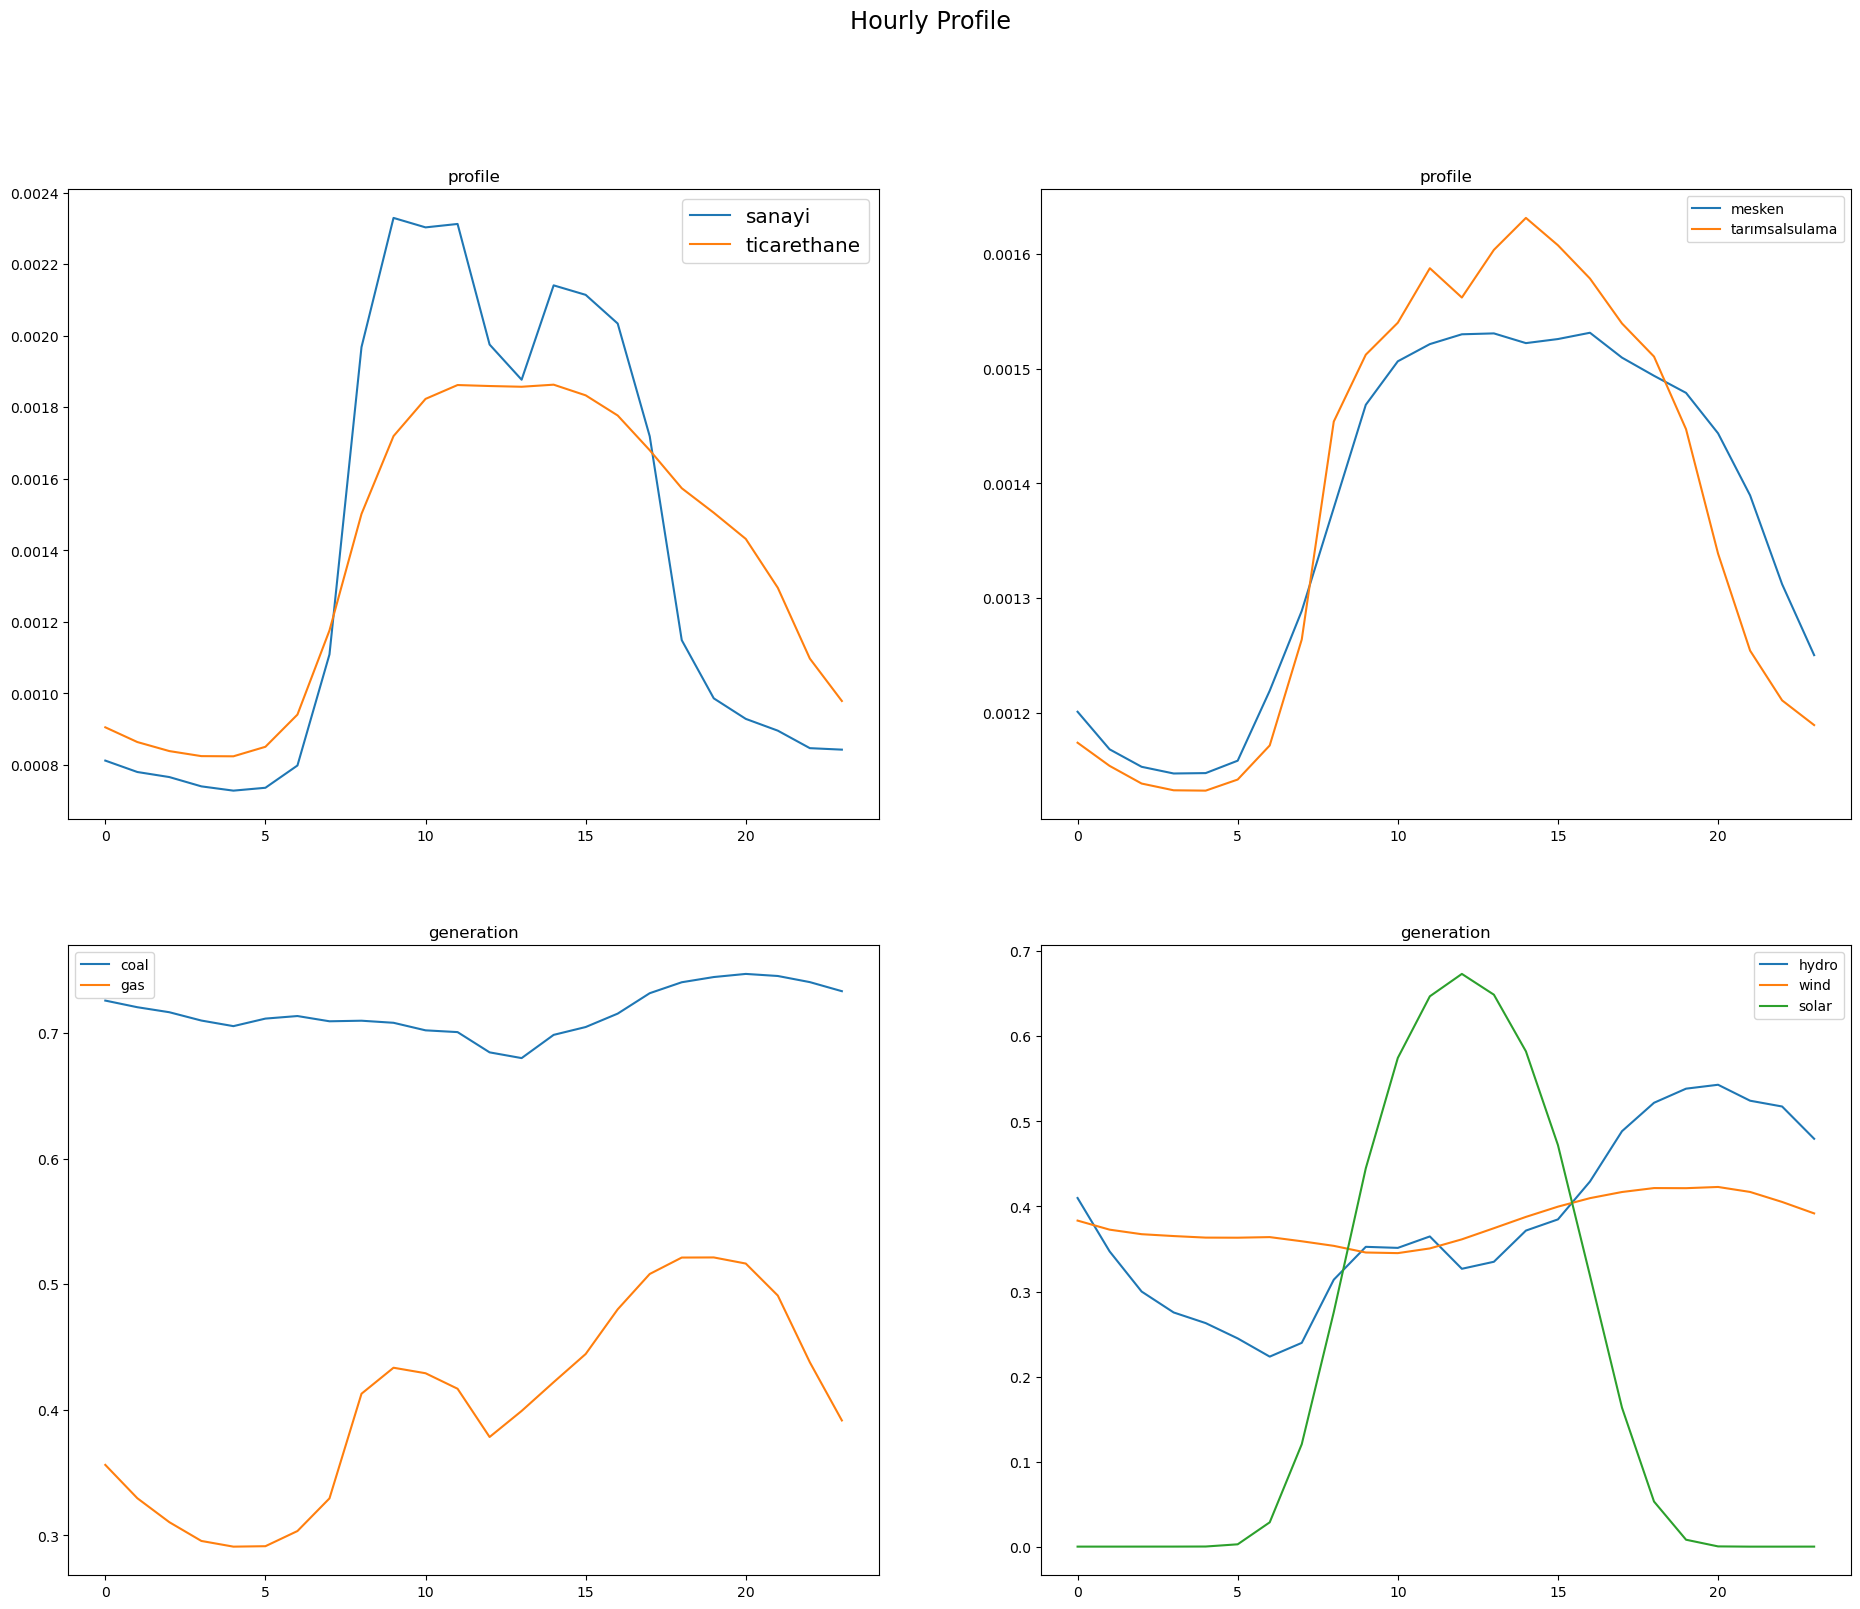

In [20]:
plt.subplots(figsize=(23,18))
plt.subplot(2, 2, 1)
plt.plot(pivothourlydata1["sanayi"] ,label="sanayi")
plt.plot(pivothourlydata1["ticarethane"] ,label="ticarethane")
plt.legend(fontsize="x-large")
plt.title('profile')
plt.subplot(2, 2,  2)
plt.plot(pivothourlydata1["mesken"] ,label="mesken")
plt.plot(pivothourlydata1["tarımsalsulama"] ,label="tarımsalsulama")
plt.legend(fontsize="x-large")
plt.title('profile')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(pivothourlydata1["coal"] ,label="coal")
plt.plot(pivothourlydata1["gas"] ,label="gas")
plt.title('generation')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(pivothourlydata1["hydro"]  ,label="hydro")
plt.plot(pivothourlydata1["wind"]  ,label="wind")
plt.plot(pivothourlydata1["solar"]  ,label="solar")
plt.title('generation')
plt.legend()
plt.suptitle('Hourly Profile',fontsize="xx-large")
plt.show()

C:\Users\srv_ipython_mce\AppData\Local\Temp\ipykernel_2192\3315931970.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


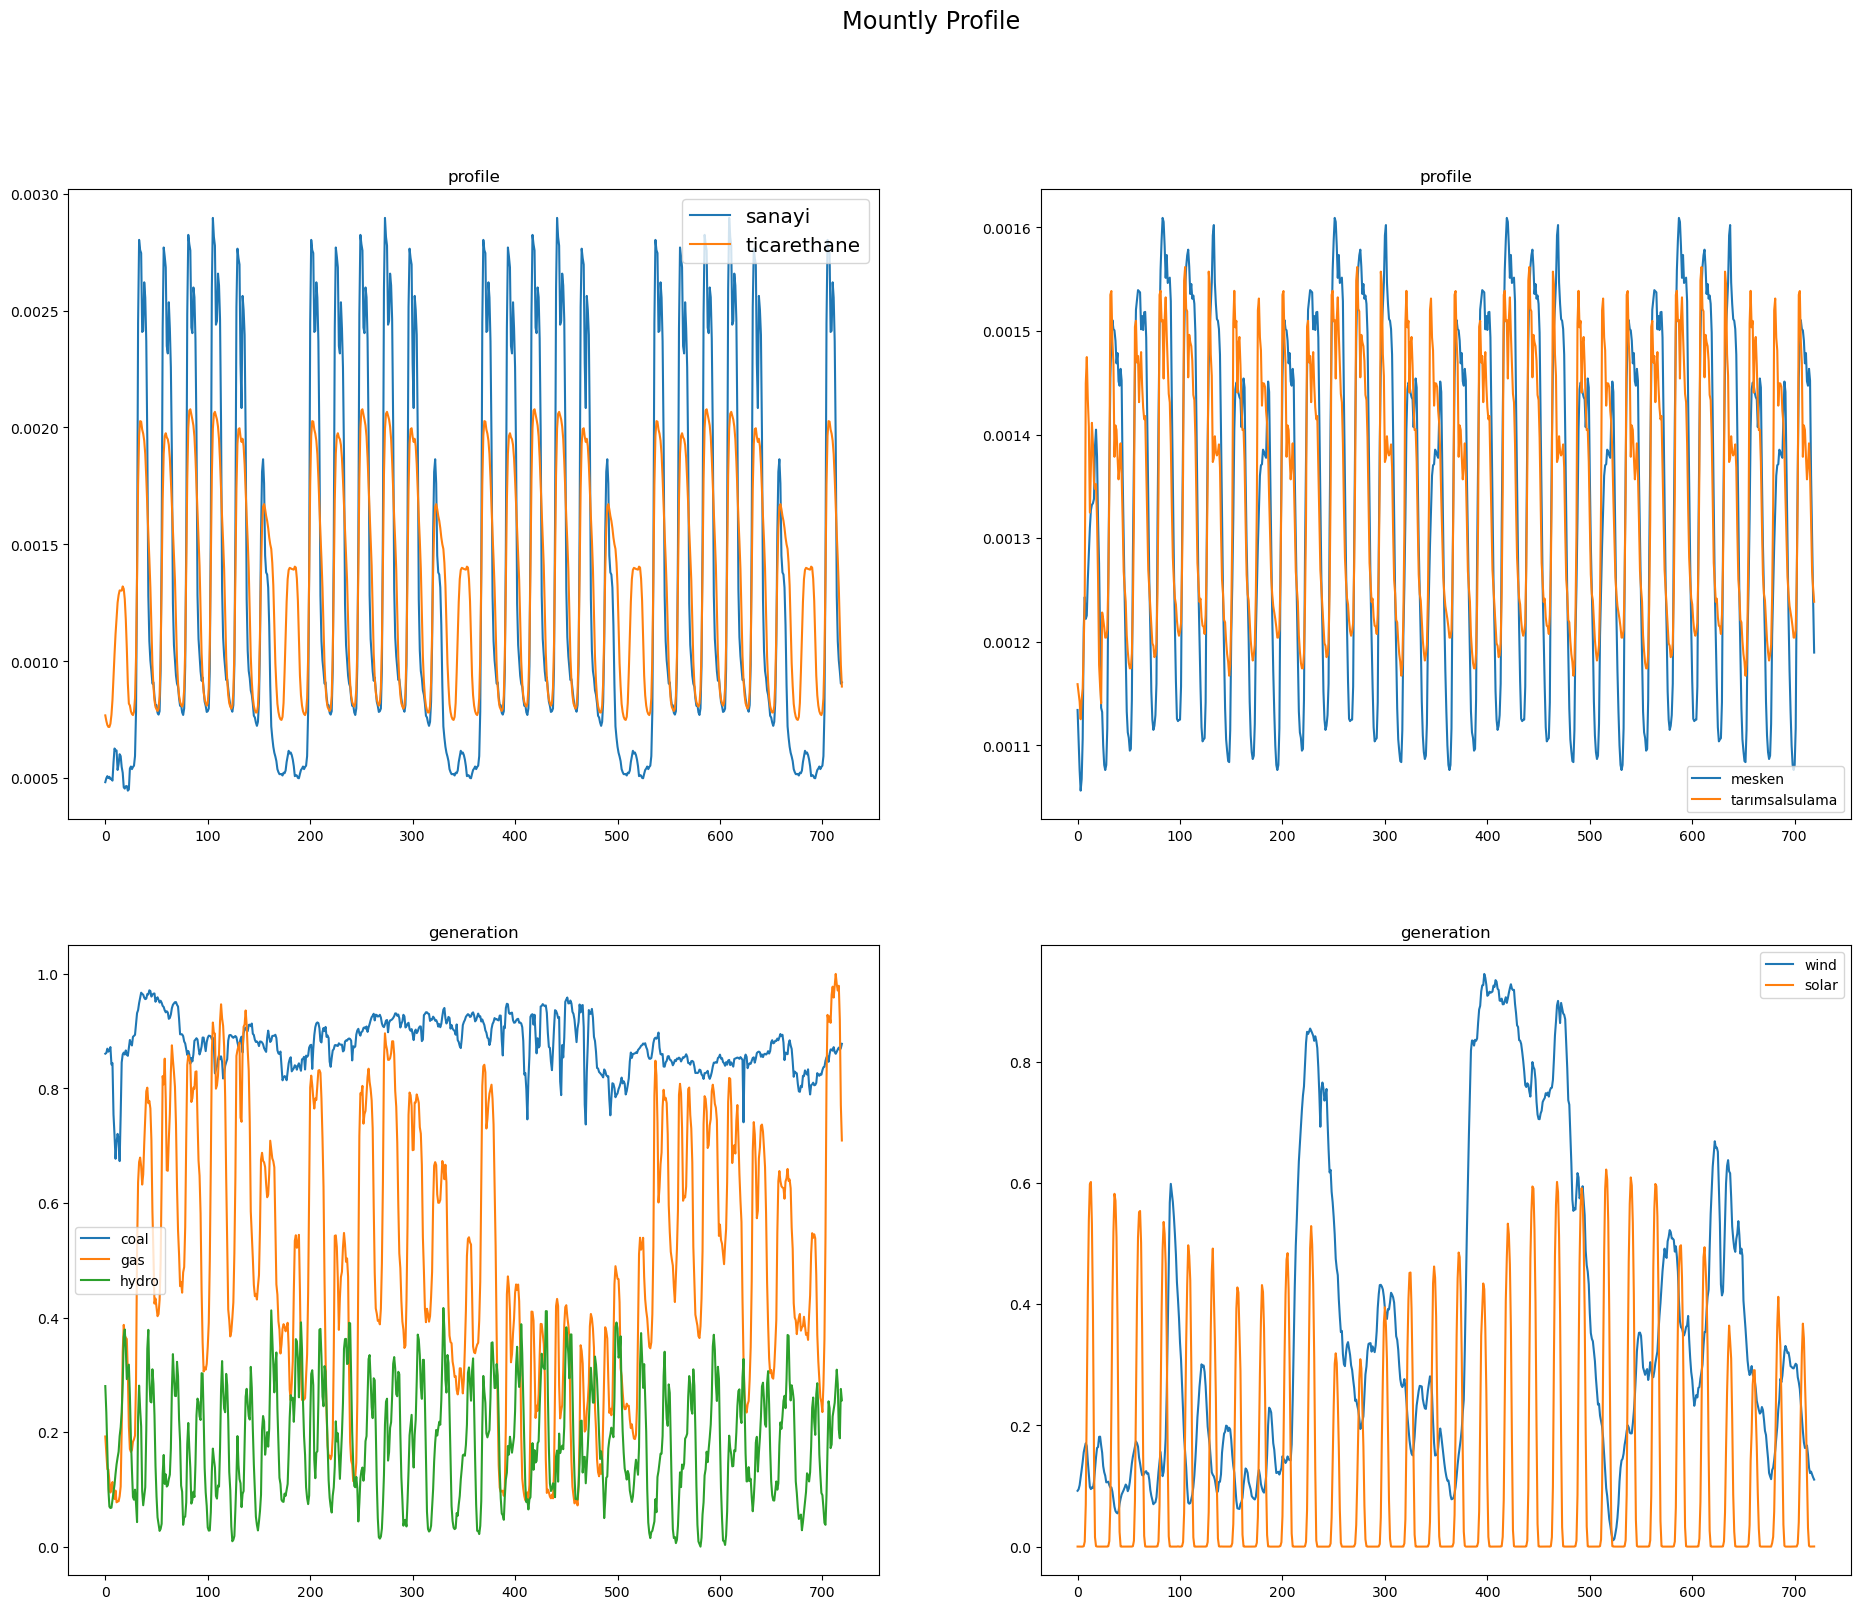

In [21]:
plt.subplots(figsize=(23,18))
plt.subplot(2, 2, 1)
plt.plot(hourlydata1["sanayi"][0:720] ,label="sanayi")
plt.plot(hourlydata1["ticarethane"][0:720] ,label="ticarethane")
plt.legend(fontsize="x-large")
plt.title('profile')
plt.subplot(2, 2,  2)
plt.plot(hourlydata1["mesken"][0:720] ,label="mesken")
plt.plot(hourlydata1["tarımsalsulama"][0:720] ,label="tarımsalsulama")
plt.legend(fontsize="x-large")
plt.title('profile')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(hourlydata1["coal"][0:720] ,label="coal")
plt.plot(hourlydata1["gas"][0:720] ,label="gas")
plt.plot(hourlydata1["hydro"][0:720]  ,label="hydro")
plt.title('generation')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(hourlydata1["wind"][0:720]  ,label="wind")
plt.plot(hourlydata1["solar"][0:720]  ,label="solar")
plt.title('generation')
plt.legend()
plt.suptitle('Mountly Profile',fontsize="xx-large")
plt.show()

In [22]:

def PORTFOLİO(a,x,y,z,t,w):
    portföy   = (x*hourlydata1["coal"] + 
                 y*hourlydata1["gas"]+ 
                 z*hourlydata1["hydro"] + 
                 t*hourlydata1["wind"] + 
                 w*hourlydata1["solar"])
    hedef     = sum(portföy)/12 * a  
    hedefTL   = hedef*hourlydata1["price"]
    sapmaMWh  = abs(hedef - portföy)
    portföyTL = ((x*hourlydata1["coal"]  *hourlydata1["price"]*1.01) 
                +(y*hourlydata1["gas"]   *hourlydata1["price"]*1.02) 
                +(z*hourlydata1["hydro"] *((hourlydata1["priceUsd"].mean()-0.5)*(hourlydata1["price"]/hourlydata1["priceUsd"])))
                +(t*hourlydata1["wind"]  *((hourlydata1["priceUsd"].mean()-1)*(hourlydata1["price"]/hourlydata1["priceUsd"])))
                +(w *hourlydata1["solar"]*((hourlydata1["priceUsd"].mean()-1.5)*(hourlydata1["price"]/hourlydata1["priceUsd"]))))
    sapmaTL   = abs(hedefTL - portföyTL)
    print((portföyTL/hedefTL).mean())
    print("seçilen\t" + a.name + "\nhedef_tüketimi =" + str(sum(hedef)) + "\nportföy_üretimi =" + str(sum(portföy)) + "\n % sapmaMW=" + str(sum(sapmaMWh)/sum(hedef)))
    print("hedef_TL " + str(sum(hedefTL)) + "\nportföyTL =" + str(sum(portföyTL)) + "\n % sapmaTL=" + str(sum(sapmaTL)/sum(hedefTL)))
    return hedefTL

In [23]:
a = PORTFOLİO(hourlydata1["mesken"],10,5,8,9,15)

10.295235084011248
seçilen	mesken
hedef_tüketimi =164798.2070878529
portföy_üretimi =164796.45085197827
 % sapmaMW=0.15841028152588582
hedef_TL 364783844.57655996
portföyTL =381017887.24237436
 % sapmaTL=0.2676637567384023
